In [1]:
!pip install -q medmnist
!pip install -q xgboost scikit-learn matplotlib seaborn opencv-python albumentations scikit-image mahotas scipy imbalanced-learn umap-learn tensorflow pillow tqdm
!mkdir class_task

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 795.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 44.4 MB/s eta 0:00:00


In [2]:
import medmnist
from medmnist import INFO
from medmnist import PathMNIST
from torchvision import transforms
from torch.utils.data import DataLoader
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import imagesize
from collections import defaultdict
import hashlib
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor

In [3]:
# data will go to ~/.medmnist by default
train_dataset = PathMNIST(split='train', download=True)
val_dataset = PathMNIST(split='val', download=True)
test_dataset = PathMNIST(split='test', download=True)

!cp /root/.medmnist/pathmnist.npz /content/class_task/

100%|██████████| 206M/206M [01:00<00:00, 3.39MB/s]



 Class distribution in train set:
  Background                    : 9366 samples
  Normal colon mucosa           : 9509 samples
  Colon mucosa                  : 10360 samples
  Colon submucosa               : 10401 samples
  Lymphoid tissue               : 8006 samples
  Debris                        : 12182 samples
  Cancer-associated stroma      : 7886 samples
  Tumor epithelium              : 9401 samples
  Mucus                         : 12885 samples


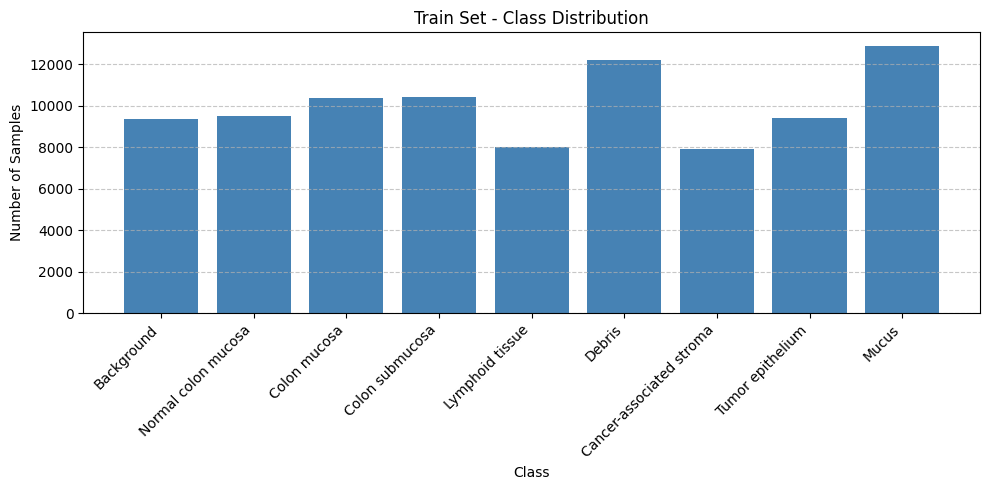


 Class distribution in validation set:
  Background                    : 1041 samples
  Normal colon mucosa           : 1057 samples
  Colon mucosa                  : 1152 samples
  Colon submucosa               : 1156 samples
  Lymphoid tissue               : 890 samples
  Debris                        : 1354 samples
  Cancer-associated stroma      : 877 samples
  Tumor epithelium              : 1045 samples
  Mucus                         : 1432 samples


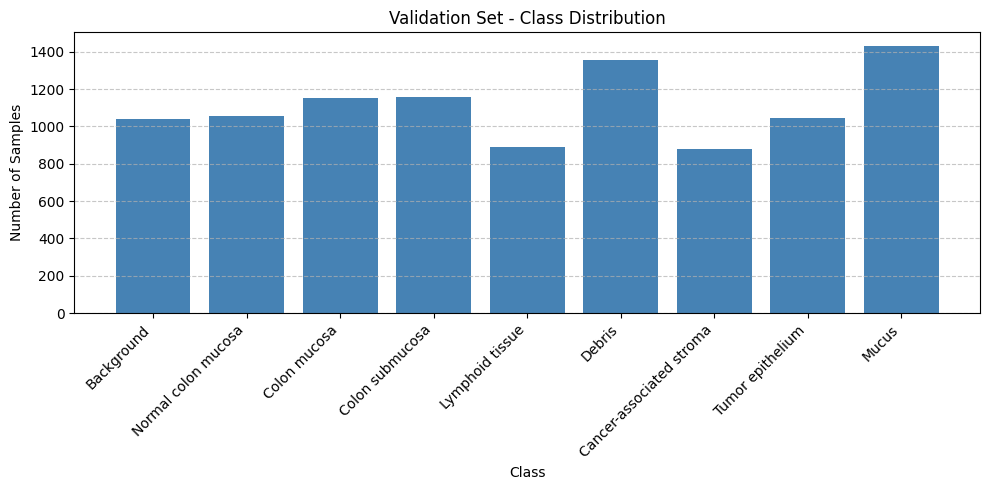


 Class distribution in test set:
  Background                    : 1338 samples
  Normal colon mucosa           : 847 samples
  Colon mucosa                  : 339 samples
  Colon submucosa               : 634 samples
  Lymphoid tissue               : 1035 samples
  Debris                        : 592 samples
  Cancer-associated stroma      : 741 samples
  Tumor epithelium              : 421 samples
  Mucus                         : 1233 samples


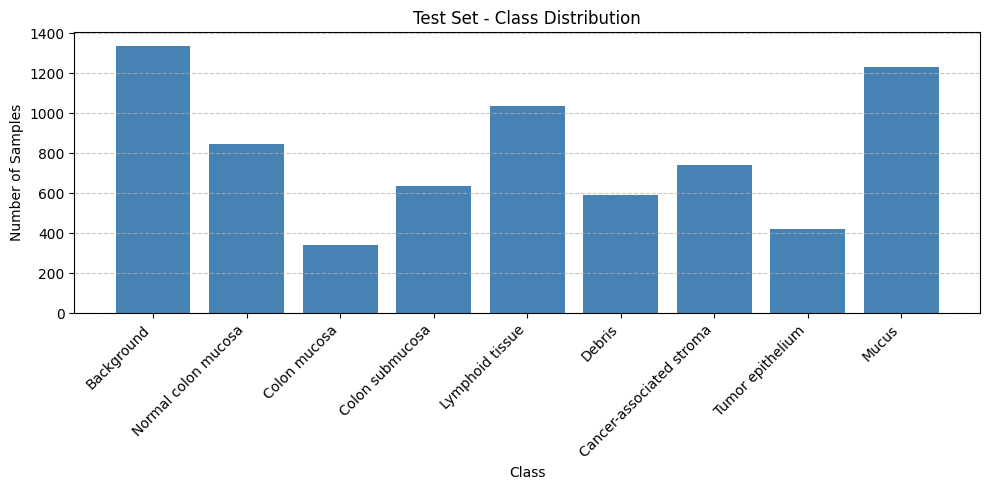

In [4]:
from collections import Counter

pathmnist_classes = {
    0: "Background",
    1: "Normal colon mucosa",
    2: "Colon mucosa",
    3: "Colon submucosa",
    4: "Lymphoid tissue",
    5: "Debris",
    6: "Cancer-associated stroma",
    7: "Tumor epithelium",
    8: "Mucus"
}

# Class distribution
def analyze_class_distribution(dataset, split_name):
    labels = dataset.labels.flatten()
    counts = Counter(labels)

    print(f"\n Class distribution in {split_name} set:")
    for cls_idx in range(9):
        class_name = pathmnist_classes[cls_idx]
        print(f"  {class_name:30s}: {counts[cls_idx]} samples")

    class_names = [pathmnist_classes[i] for i in range(9)]
    class_counts = [counts[i] for i in range(9)]

    plt.figure(figsize=(10, 5))
    bars = plt.bar(class_names, class_counts, color='steelblue')
    plt.title(f"{split_name.capitalize()} Set - Class Distribution")
    plt.xlabel("Class")
    plt.ylabel("Number of Samples")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

analyze_class_distribution(train_dataset, "train")
analyze_class_distribution(val_dataset, "validation")
analyze_class_distribution(test_dataset, "test")


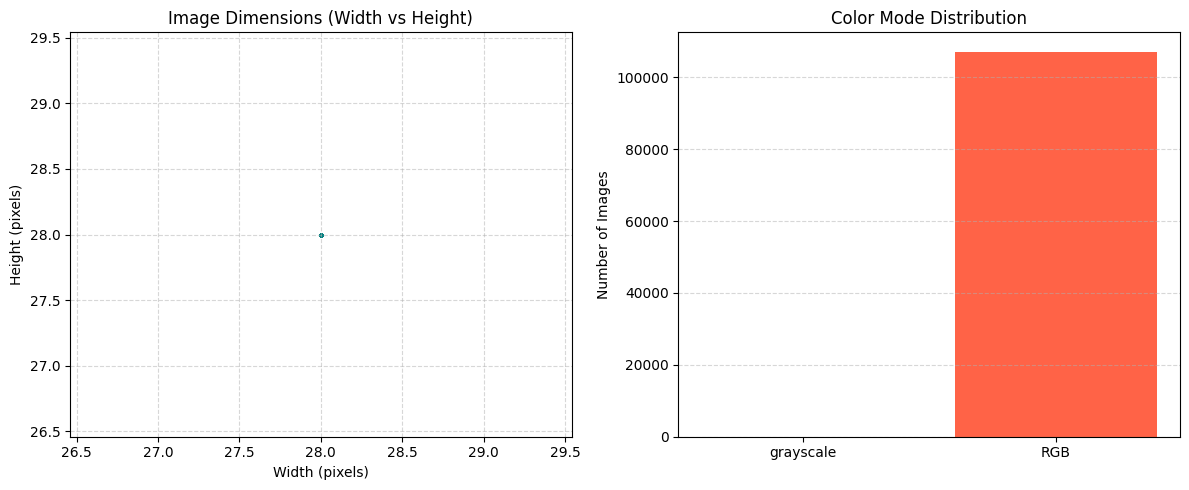

In [5]:
all_images = np.concatenate([train_dataset.imgs, val_dataset.imgs, test_dataset.imgs], axis=0)  # shape: (N, H, W, C)

heights = [img.shape[0] for img in all_images]
widths  = [img.shape[1] for img in all_images]

color_modes = {"grayscale": 0, "RGB": 0}
for img in all_images:
    if img.shape[-1] == 1:
        color_modes["grayscale"] += 1
    elif img.shape[-1] == 3:
        color_modes["RGB"] += 1

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Image Dimensions
axes[0].scatter(widths, heights, alpha=0.3, color="teal", s=2)
axes[0].set_title("Image Dimensions (Width vs Height)")
axes[0].set_xlabel("Width (pixels)")
axes[0].set_ylabel("Height (pixels)")
axes[0].grid(True, linestyle="--", alpha=0.5)

# Color Mode Distribution
axes[1].bar(color_modes.keys(), color_modes.values(), color=['gray', 'tomato'])
axes[1].set_title("Color Mode Distribution")
axes[1].set_ylabel("Number of Images")
axes[1].grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()